In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import numpy as np
from tensorflow.keras.preprocessing import image
from skimage.io import imread
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr


In [4]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

print(labelStringArr)

img_df.sample(n=10)

['MKD' 'HRV' 'ISL' 'IRL' 'ITA' 'HUN' 'LVA' 'GBR' 'FRA' 'LTU' 'AUT' 'SVN'
 'FIN' 'ESP' 'NOR' 'BGR' 'PRT' 'SVK' 'BEL' 'EST' 'POL' 'CZE' 'NLD' 'CHE'
 'DNK' 'SWE']


,path,label
23796,/home/pascal_steiger/Downloads/data/CHE/img_46...,CHE
10763,/home/pascal_steiger/Downloads/data/AUT/img_AU...,AUT
19053,/home/pascal_steiger/Downloads/data/BEL/img_50...,BEL
22329,/home/pascal_steiger/Downloads/data/CZE/img_CZ...,CZE
6495,/home/pascal_steiger/Downloads/data/LVA/img_LV...,LVA
27,/home/pascal_steiger/Downloads/data/MKD/img_MK...,MKD
2002,/home/pascal_steiger/Downloads/data/ISL/img_IS...,ISL
16154,/home/pascal_steiger/Downloads/data/BGR/img_BG...,BGR
4536,/home/pascal_steiger/Downloads/data/ITA/img_IT...,ITA
7738,/home/pascal_steiger/Downloads/data/GBR/img_53...,GBR


In [5]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)


                                                    path label
1718   /home/pascal_steiger/Downloads/data/HRV/img_HR...   HRV
9984   /home/pascal_steiger/Downloads/data/LTU/img_LT...   LTU
6957   /home/pascal_steiger/Downloads/data/LVA/img_LV...   LVA
18449  /home/pascal_steiger/Downloads/data/SVK/img_SV...   SVK
23371  /home/pascal_steiger/Downloads/data/NLD/img_52...   NLD
(21234, 2)
                                                    path label
23620  /home/pascal_steiger/Downloads/data/CHE/img_46...   CHE
8918   /home/pascal_steiger/Downloads/data/FRA/img_44...   FRA
9498   /home/pascal_steiger/Downloads/data/LTU/img_LT...   LTU
15980  /home/pascal_steiger/Downloads/data/BGR/img_BG...   BGR
13950  /home/pascal_steiger/Downloads/data/ESP/img_ES...   ESP
(5309, 2)


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(299, 299),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(299, 299),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 21234 validated image filenames belonging to 26 classes.
Found 5309 validated image filenames belonging to 26 classes.


In [8]:
with tf.device("/device:GPU:1"):
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    tl_incep = InceptionV3(include_top=True,weights="imagenet")
    tl_incep = tf.keras.Model(tl_incep.input, tl_incep.layers[-2].output)
    for layer in tl_incep.layers:
        layer.trainable = False

    for layer in tl_incep.layers[-5:]:
        layer.trainable = True 
    print(tl_incep.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
with tf.device("/device:GPU:1"):

    I = Input(shape=(299, 299, 3))



    x = tl_incep(I)


    dense = Dense(1024, activation='relu', name='denserelu')(x)
    
    dropout = Dropout(0.1)(dense)

    dense2 = Dense(512, activation='relu', name='denserelu2')(dropout)
    
    dropout2 = Dropout(0.1)(dense2)

    dense3 = Dense(26, activation='softmax', name='my_dense')(dropout2)

    #prediction = Dense(26, activation='softmax', name='prediction')



    #out2 = prediction(x)


    new_model2 = tf.keras.Model(I, dense3)

    new_model2.summary()





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
denserelu (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
denserelu2 (Dense)           (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
my_dense (Dense)             (None, 26)                1333

In [10]:
# define callbacks for early stopping

early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [11]:
def unwrap_model(model):
    mdl = model.get_layer('model')
    inp = mdl.input
    out = model.get_layer('denserelu')(mdl.output)
    out = model.get_layer('dropout')(out)
    out = model.get_layer('denserelu2')(out)
    out = model.get_layer('dropout_1')(out)
    out = model.get_layer('my_dense')(out)
    return tf.keras.Model(inp, out)   
    
new_model2 = unwrap_model(new_model2)

    
new_model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [12]:
with tf.device("/device:GPU:1"):
    new_model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

with tf.device("/device:GPU:1"):
    history = new_model2.fit(
          train_generator,
          epochs=200,
          verbose = 1,
          callbacks=callbacks,
          #steps_per_epoch=2000 // 32,
          validation_data=validation_generator)
    new_model2.save('CNN-TL_incep_v2.h5')

Epoch 1/200
664/664 [==============================] - 558s 828ms/step - loss: 2.9337 - sparse_categorical_accuracy: 0.1428 - val_loss: 2.6624 - val_sparse_categorical_accuracy: 0.2115
Epoch 2/200
664/664 [==============================] - 541s 815ms/step - loss: 2.6809 - sparse_categorical_accuracy: 0.2019 - val_loss: 2.5786 - val_sparse_categorical_accuracy: 0.2358
Epoch 3/200
664/664 [==============================] - 536s 806ms/step - loss: 2.6053 - sparse_categorical_accuracy: 0.2268 - val_loss: 2.5221 - val_sparse_categorical_accuracy: 0.2501
Epoch 4/200
664/664 [==============================] - 538s 810ms/step - loss: 2.5546 - sparse_categorical_accuracy: 0.2359 - val_loss: 2.4614 - val_sparse_categorical_accuracy: 0.2609
Epoch 5/200
664/664 [==============================] - 533s 803ms/step - loss: 2.5200 - sparse_categorical_accuracy: 0.2450 - val_loss: 2.4678 - val_sparse_categorical_accuracy: 0.2539
Epoch 6/200
664/664 [==============================] - 538s 811ms/step - lo


Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 45/200
664/664 [==============================] - 570s 858ms/step - loss: 1.9928 - sparse_categorical_accuracy: 0.3852 - val_loss: 2.2370 - val_sparse_categorical_accuracy: 0.3302
Epoch 46/200
664/664 [==============================] - 535s 805ms/step - loss: 1.9903 - sparse_categorical_accuracy: 0.3864 - val_loss: 2.2464 - val_sparse_categorical_accuracy: 0.3343
Epoch 47/200
664/664 [==============================] - 528s 795ms/step - loss: 1.9732 - sparse_categorical_accuracy: 0.3872 - val_loss: 2.2397 - val_sparse_categorical_accuracy: 0.3304
Epoch 48/200
664/664 [==============================] - 527s 794ms/step - loss: 1.9781 - sparse_categorical_accuracy: 0.3874 - val_loss: 2.2519 - val_sparse_categorical_accuracy: 0.3277
Epoch 49/200
664/664 [==============================] - 531s 799ms/step - loss: 1.9769 - sparse_categorical_accuracy: 0.3870 - val_loss: 2.2427 - val_sparse_categorical_accura

Epoch 88/200
664/664 [==============================] - 537s 808ms/step - loss: 1.8769 - sparse_categorical_accuracy: 0.4154 - val_loss: 2.2305 - val_sparse_categorical_accuracy: 0.3453
Epoch 89/200
664/664 [==============================] - 568s 855ms/step - loss: 1.8708 - sparse_categorical_accuracy: 0.4180 - val_loss: 2.2289 - val_sparse_categorical_accuracy: 0.3404

Epoch 00089: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 90/200
664/664 [==============================] - 529s 796ms/step - loss: 1.8737 - sparse_categorical_accuracy: 0.4168 - val_loss: 2.2217 - val_sparse_categorical_accuracy: 0.3466
Epoch 91/200
664/664 [==============================] - 531s 799ms/step - loss: 1.8687 - sparse_categorical_accuracy: 0.4171 - val_loss: 2.2169 - val_sparse_categorical_accuracy: 0.3477
Epoch 92/200
664/664 [==============================] - 530s 799ms/step - loss: 1.8667 - sparse_categorical_accuracy: 0.4248 - val_loss: 2.2279 - val_sparse_categorical_accura

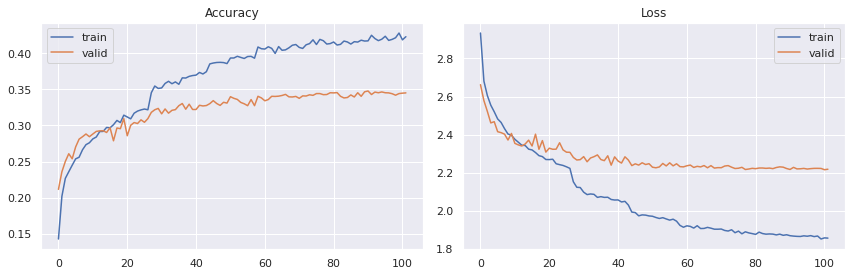

In [13]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(299,299)-tl_incepv2.png')

plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=5309
batch_size=32
Y_pred = new_model2.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = sorted(labelStringArr)
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[ 60   5   0   9  11  13   3   4   2   5   7   3   4   5   3   3   2   3
    2  10   8   3   1   8  17   4]
 [ 11  37   2  12   5  13   2   3   3  11  20   2   5   9   0   2   0   2
    1  35   1   3   2   2   2   2]
 [  3   0  88   3   3   1  20   1   1   2   0   6  17   0   5   7   4   2
   19   3   3   1   5   7   3   1]
 [ 14   7   4 102   2   4   3   3   0   3   8   1   3   1   2   4   3   2
    3   4   6   1   1   5   4   4]
 [ 14   9   8   2  45  18  10   6   3   3   7   3  13   6   1   2   5   4
    3  12   5  10   5   8   7   8]
 [ 10   2   1   6  11  87   5   4   2   0   8   3   7   7   2   1   2   3
    0  12   5   5   2   6   1   4]
 [ 11   4  12   5   3   5 100   8   3  10   7  20   6   7  10   9   2   4
   15   6   4  10  22  11   8   5]
 [  2   3   1   2   2   3   5  79   0   6   0   1   1   1   1   1  15  17
    0  14   4   7   2   1   6  14]
 [  2   0   1   4   3   5   1   1 121   0   0   2   3   2   1   1   2   6
    2   5  14   1   4   2   4  29]
 [